## Network Centrality for 2017 Crimes

### Based off of the work of Geoff Boeing on this <a href="https://github.com/gboeing/osmnx-examples/blob/master/notebooks/08-example-line-graph.ipynb">repo</a>.

In [1]:
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

import pandas as pd
pd.set_option('display.max_colwidth', -1)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import hdfs3 as hdfs
import os
import networkx as nx
import osmnx as ox

from tqdm import tqdm

from shapely.geometry import Point, LineString

%matplotlib inline

# Enable osmnx to cache requests as frequent calls to OpenStreetMaps' API will be eventually be denied
ox.config(use_cache=True, log_console=False)

In [2]:
# The version is important as the cell that inverts nodes aand edges will not work with a 
# lessser version of networkx
nx.__version__

'2.2rc1.dev_20180430151336'

### Read in our crime data from our distributed data store running off of a hadoop cluster

In [ ]:
hdfsFS = hdfs.HDFileSystem(os.environ["NAMENODE_HOSTNAME"], port=int(os.environ["NAMENODE_PORT"]))

In [ ]:
with hdfsFS.open('/user/root/data/incidents_part1_part2.csv') as f:
    data = pd.read_csv(f, low_memory=False)

### Drop a few surplus geo data columns from our data

In [ ]:
df = data.drop(['the_geom','the_geom_webmercator','point_x','point_y','objectid'],axis=1)

In [ ]:
# Convert the date column of the occurrence of the crime to enable us select out the year we require (2017).
df['dispatch_date'] = pd.to_datetime(df['dispatch_date'])

## The data as released from Philly's open data portal does not match the street names as released on the OpenStreetsMap data. 

## We therefore do some data editing to match the two sets 

In [ ]:
df['location_block'] = df['location_block'].str.replace(' S ', ' SOUTH ')
df['location_block'] = df['location_block'].str.replace(' N ', ' NORTH ')
df['location_block'] = df['location_block'].str.replace(' E ', ' EAST ')
df['location_block'] = df['location_block'].str.replace(' W ', ' WEST ')
df['location_block'] = df['location_block'].str.replace('/', ' & ')
df['location_block'] = df['location_block'].str.replace(' ST', ' STREET')
df['location_block'] = df['location_block'].str.replace(' STREETREET', ' STREET')
df['location_block'] = df['location_block'].str.replace(' AV', ' AVENUE')
df['location_block'] = df['location_block'].str.replace(' AVENUEE ', ' AVENUE ')
df['location_block'] = df['location_block'].str.replace(' AVENUEE', ' AVENUE')
df['location_block'] = df['location_block'].str.replace(' BLVD', ' BOULEVARD')

In [ ]:
# Retrieve our 2017 crime data
df_2017 = df[df.dispatch_date.dt.year == 2017]

In [ ]:
df_2017.head()

In [3]:
# Get the graph for Philadelphia
G = ox.graph_from_place('Philadelphia, Pennsylvania, USA', network_type='drive')

### Convert the edges from our graph into a pandas dataframe for data manipulation

In [4]:
edges_data = nx.to_pandas_edgelist(G)[['name','source','target','geometry']].dropna(subset=['geometry'])

In [ ]:
edges_data.head(5)

### Extract only the columns we need from our crimes data i.e. mostly columns relevant to our street data

In [ ]:
crimesloc_2017 = df_2017[['lng','lat','hour_','location_block']].copy()

In [ ]:
crimesloc_2017.reset_index(drop=True,inplace=True)

In [ ]:
crimesloc_2017.head()

In [ ]:
len(crimesloc_2017)

## Data Matching

### At this point we loop through our crime and edge data finding the the closest street to the location of our crimes.

We begin by retrieving all the streets from our edges data that match the street indicated on our crime's location block. For example for a crime that occured on <b>'900 Block Wolf Street'</b> we retrieve all edges with the name <b>'Wolf Street'</b>.

As we still expect some streets data to not match exactly with our <b>location data</b>, as there are a number of streets in our edges data without a <b>name</b> value, we also include any streets that contain 'nan' in their name value. We do this as there is no better way to identify the names of the streets in our edges data and some streets are longer than what is expressed in the geometries of the edges.

Once we have our collection of matching and 'nan' streets, we calculate the distance from our crime location to each edge. We do this using Shapely's distance() method using the Lat, Long for our crime points as the Point() and our streets Linestring data for our edges. Once we have our collection of distances, we extract the edge that is closest to our location and add it to our crimes data as the presumed edge at which our crime occurred.

#### Some Notes
In looping through the data I found several instances where the <b>name</b> value of our edges was a list instead of a string, this led me to use the get method for the <b>name</b> value because in some instances the name value could contain up to 3 street names.

I also noticed that some location blocks were a single name such as 'PIA' instead of the minimum two word string containing the name and either <i>'street','avenue', or 'boulevard'</i>. This led to a slow crawl through the data with changes whenever an IndexError or KeyError were encountered. For example, we would change 'PIA' to 'PIA WAY'. I chose to manually correct the errors as they weren't that many in our data.

In [ ]:
correction = 0

In [ ]:
crimesloc_2017.iloc[correction].location_block

In [ ]:
crimesloc_2017.at[correction,'location_block'] = 'ENTERPRISE STREET'
crimesloc_2017.iloc[correction].location_block

In [ ]:
def closest_d(df1,df2):
    cols = ['d','name','source','target','geometry']
    clo_d = pd.DataFrame(columns=cols)
    
    with tqdm(total=len(list(df1.loc[correction:].iterrows())),unit=' points') as pbar:
        for index,row in df1.loc[correction:].iterrows():
            distances = []
            s = row['location_block'].split(' ')[-2:]
            df3 = df2[(df2['name'].str.get(0).str.contains('' + s[0] + ' ' + s[1],case=False,na=True)) | \
                    (df2['name'].str.get(1).str.contains('' + s[0] + ' ' + s[1],case=False,na=True))]
            for i,r in df3.iterrows():
                distances.append([r['geometry'].distance(Point(row['lng'],row['lat'])),\
                                r['name'],r['source'],r['target'],r['geometry']])
            d_df = pd.DataFrame(distances,columns=cols)
            clo_d = clo_d.append(d_df.loc[d_df['d'].idxmin()],ignore_index=True)
            pbar.update(1)
        return clo_d

In [ ]:
c_d = closest_d(crimesloc_2017,edges_data)

In [8]:
c_d = pd.read_csv('crimesloc_2017.csv')
c_d.drop('Unnamed: 0',axis=1,inplace=True)

### The nearest edge to each of our crimes

In [9]:
c_d.head()

,d,name,source,target,geometry
0,0.013836140086994167,NaN,5335439475,5335439475,"LINESTRING (-75.15524499999999 39.9978619, -75.1552805 39.9978505, -75.1553084 39.9978301, -75.1553167 39.9978166, -75.1553248 39.9978034, -75.1553277 39.997774, -75.1553167 39.9977457, -75.1552932 39.9977223, -75.15526029999999 39.9977069, -75.1552224 39.9977016, -75.1551845 39.997707, -75.1551517 39.9977224, -75.15512819999999 39.9977458, -75.15511720000001 39.9977741, -75.1551202 39.9978036, -75.1551377 39.9978312, -75.1551673 39.9978519, -75.1552049 39.9978627, -75.15524499999999 39.9978619)"
1,0.0035733201741938985,NaN,110522140,601299549,"LINESTRING (-75.1487571 40.0204531, -75.14898820000001 40.0202927, -75.1492229 40.0201298, -75.1492863 40.0200934, -75.14936710000001 40.0200663)"
2,0.008133432595713063,NaN,109764856,109764871,"LINESTRING (-75.132181 39.974605, -75.132239 39.974625, -75.132288 39.974623)"
3,0.009330208561403604,NaN,109735929,109736008,"LINESTRING (-74.997061 40.048655, -74.996762 40.048771, -74.99638 40.048906, -74.99606199999999 40.049011, -74.995755 40.049109, -74.99541499999999 40.049208, -74.99381339999999 40.0496629)"
4,0.006468308635152754,NaN,4462102126,4462102156,"LINESTRING (-75.04763440000001 40.055512, -75.0475679 40.0556222, -75.0475364 40.0556884, -75.0475122 40.0557551, -75.04748309999999 40.0558654, -75.0474636 40.0559111, -75.0474395 40.0559506, -75.0474093 40.0559865, -75.0468059 40.0565908, -75.0467816 40.0566152, -75.0467227 40.0566742)"


In [ ]:
# c_d.to_csv('crimesloc_2017.csv')

In [ ]:
len(c_d)

### A simple concatenation of our two dataframes would follow

In [ ]:
results_2017 = pd.concat([crimesloc_2017, c_d], axis=1,ignore_index=True)

In [ ]:
results_2017.columns = ['lng','lat','hour_','location_block','d','name','source','target','geometry']
results_2017.head(5)

In [ ]:
results_2017.isnull().any()

## We then group our data using the <i>source</i> and <i>target</i> column of our edges to establish a count of crimes at each edge.

In [ ]:
results_2017_2 = results_2017.groupby(['source','target'])
r2017_grouped = results_2017_2.location_block.count().reset_index()
r2017_grouped.columns=['source','target','crime_count']
r2017_grouped.head()

In [ ]:
len(r2017_grouped)

## Reverting to our Street Network

Once grouped, we retrieve our full network data inclusive of all edge attributes

In [ ]:
full_edges_data = nx.to_pandas_edgelist(G)
full_edges_data.head(2)

In [ ]:
len(full_edges_data)

### We then merge our grouped crimes data to our full graph on the <i>source</i> and <i>target</i> columns and fill in those edges without crimes to have a value of 0 instead of 'nan'

In [ ]:
full_merged = pd.merge(left=full_edges_data,right=r2017_grouped,how='left',\
                       left_on=['source','target'],right_on=['source','target'])
full_merged['crime_count'].fillna(0, inplace=True)

In [ ]:
full_merged.head(2)

In [10]:
# full_merged.to_csv('full_edges_2017.csv')
full_merged = pd.read_csv('full_edges_2017.csv')
full_merged.drop('Unnamed: 0',axis=1,inplace=True)

In [11]:
len(full_merged)

61859

## The result is our urban street network with a new attribute of crime counts

In [12]:
full_merged.head()

,access,bridge,geometry,highway,junction,lanes,length,maxspeed,name,oneway,osmid,ref,service,source,target,tunnel,crime_count
0,NaN,NaN,NaN,residential,NaN,NaN,15.587,NaN,South 24th Street,False,12189760,NaN,NaN,109903872,469948693,NaN,0.0
1,NaN,NaN,"LINESTRING (-75.18837379999999 39.9196918, -75.18812269999999 39.9194224, -75.1879605 39.9192863, -75.187809 39.9191725, -75.1876494 39.9190694, -75.1874632 39.9189685, -75.18728179999999 39.9188885, -75.1871017 39.9188266, -75.1870328 39.9188061, -75.1869623 39.9187851, -75.1868419 39.9187507, -75.18668460000001 39.9187154, -75.1866031 39.9187069, -75.1860543 39.91865)",primary,NaN,NaN,239.255,NaN,Oregon Avenue,True,"[96161681, 423969707]",NaN,NaN,109903872,2124308758,NaN,0.0
2,NaN,NaN,NaN,secondary,NaN,NaN,60.838,NaN,Erie Avenue,False,133509691,NaN,disused_tram,110034951,110528333,NaN,0.0
3,NaN,NaN,NaN,secondary,NaN,NaN,33.682,NaN,Erie Avenue,False,133509691,NaN,disused_tram,110034951,634994844,NaN,0.0
4,NaN,NaN,"LINESTRING (-75.123425 40.007212, -75.1236263 40.0062889, -75.1236912 40.0059911, -75.12371 40.005905, -75.123949 40.004814, -75.12400700000001 40.004542, -75.124163 40.003829)",tertiary,NaN,NaN,381.389,NaN,B Street,False,49990122,NaN,NaN,110034951,110211252,NaN,0.0


In [13]:
full_merged_nx = nx.from_pandas_edgelist(full_merged,'source','target',edge_attr=True)

for n in full_merged_nx.edges.items():
    for k,v in n[1].copy().items():
        if v != v:
            n[1].pop(k)

In [ ]:
# Show our data
full_merged_nx.edges.data()

</br></br>

## Centrality

Finally we calculate our centrality measures for each street using our <b><i>crime_count</i></b> edge attribute as our distance variable.

In [41]:
node_centrality = nx.closeness_centrality(full_merged_nx,distance='crime_count')

In [51]:
bbox = (-75.1215,39.5807,-75.0702,39.5622)

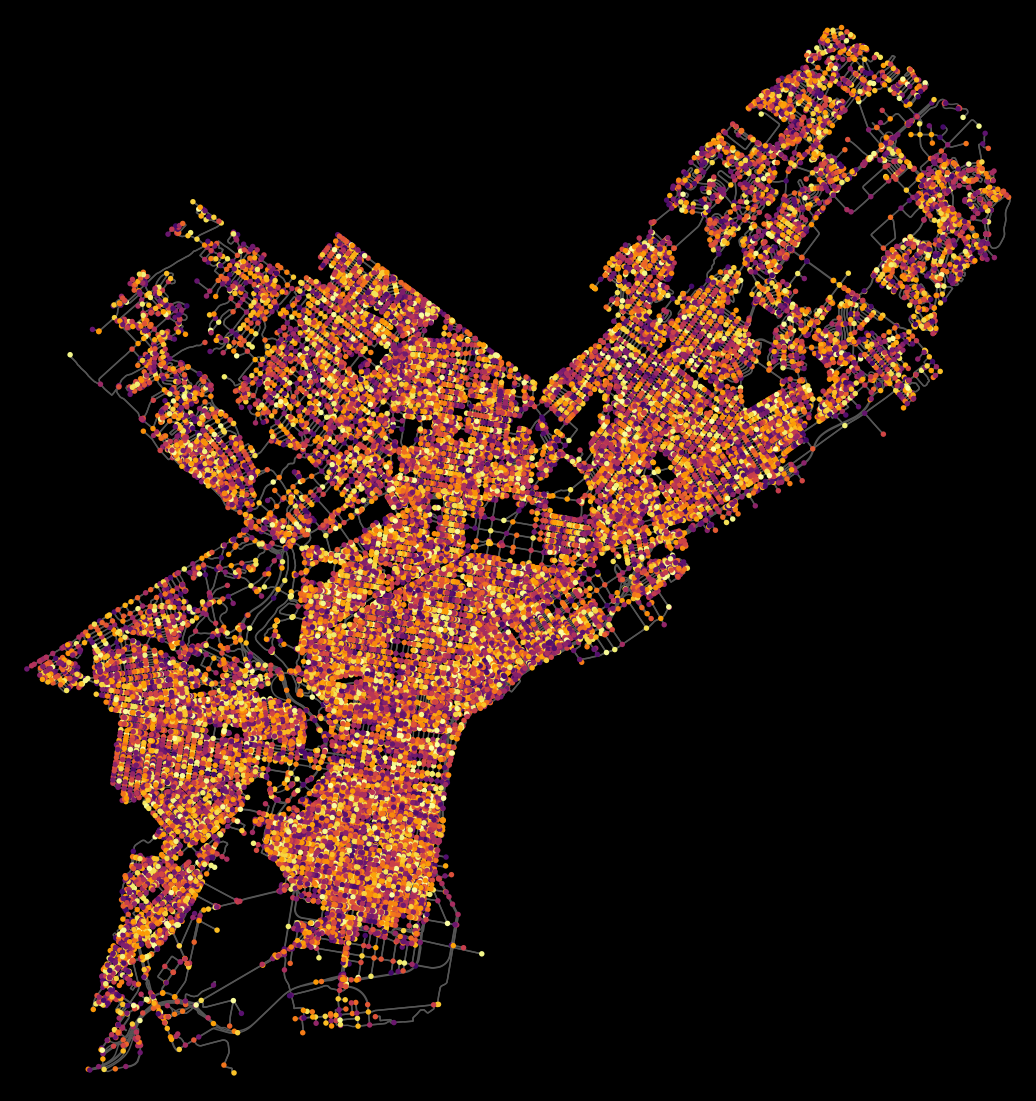

In [55]:
# plot it
df_p = pd.DataFrame(data=pd.Series(node_centrality).sort_values(), columns=['cc'])
df_p['colors'] = ox.get_colors(n=len(df_p), cmap='inferno', start=0.2)
df_p = df_p.reindex(full_merged_nx.nodes())
nc = df_p['colors'].tolist()
fig, ax = ox.plot_graph(G, \
                        bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1, fig_height=20,fig_width=20)

In [14]:
edge_centrality = nx.closeness_centrality(nx.line_graph(full_merged_nx),distance='crime_count')

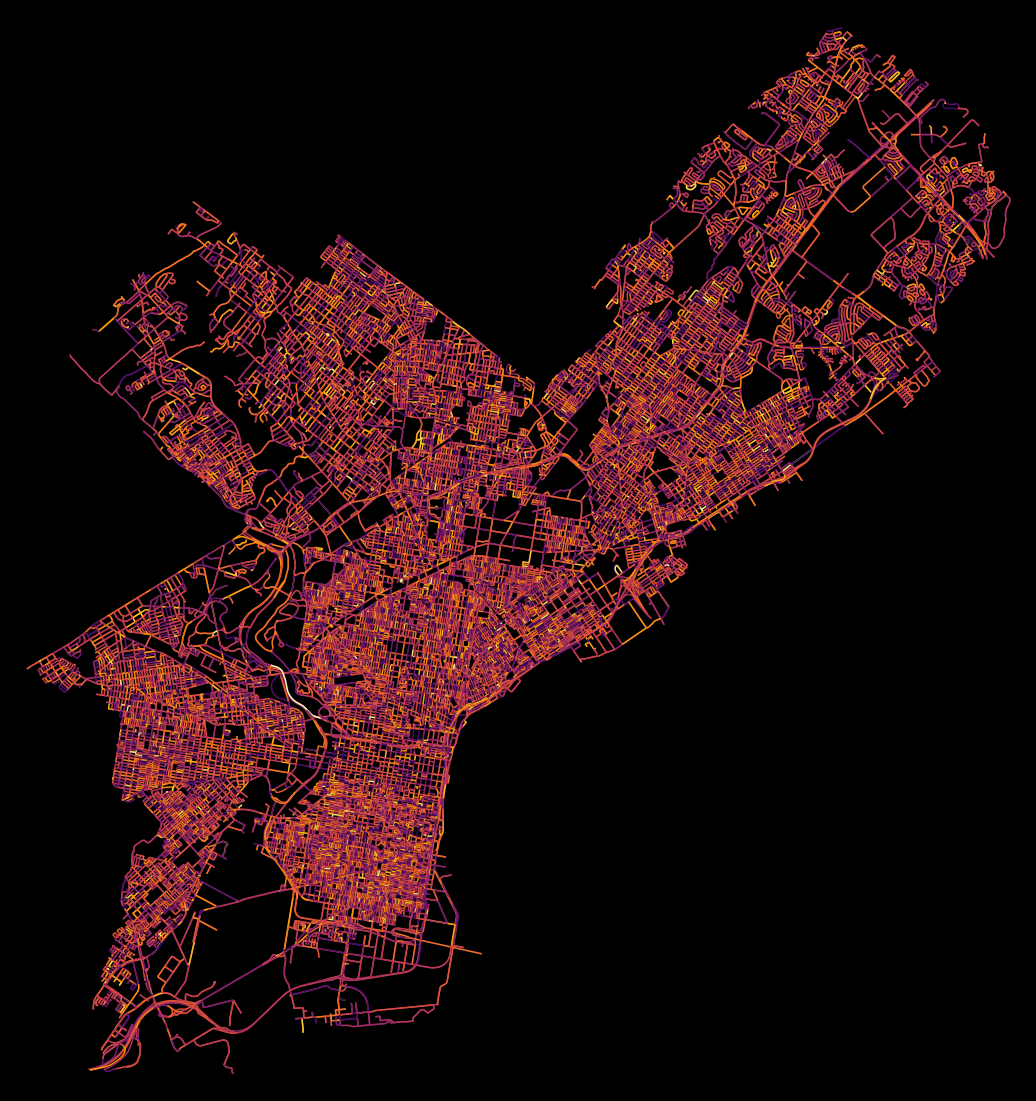

In [40]:
# list of edge values for the orginal graph
ev = []
for edge in full_merged_nx.edges():
    try:
        ev.append(edge_centrality[edge])
    except KeyError:
        pass

# color scale converted to list of colors for graph edges
norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(G, bgcolor='k', axis_off=True, node_size=0, node_color='w', node_edgecolor='gray', node_zorder=2,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1, fig_height=20,fig_width=20)